In [1]:
import warnings
warnings.filterwarnings("ignore")

from data_loader import DataLoader
from models import MODELS
from misc.evaluation_metrics import *
from attacks import *
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import json

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.backend import sign

def clip_eta(eta, norm, eps):
    """
    Helper function to clip the perturbation to epsilon norm ball.
    :param eta: A tensor with the current perturbation.
    :param norm: Order of the norm (mimics Numpy).
                Possible values: np.inf, 1 or 2.
    :param eps: Epsilon, bound of the perturbation.
    """

    # Clipping perturbation eta to self.norm norm ball
    if norm not in [np.inf, 1, 2]:
        raise ValueError("norm must be np.inf, 1, or 2.")
    axis = list(range(1, len(eta.get_shape())))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        eta = tf.clip_by_value(eta, -eps, eps)
    else:
        if norm == 1:
            raise NotImplementedError("")
            # This is not the correct way to project on the L1 norm ball:
            # norm = tf.maximum(avoid_zero_div, reduce_sum(tf.abs(eta), reduc_ind, keepdims=True))
        elif norm == 2:
            # avoid_zero_div must go inside sqrt to avoid a divide by zero in the gradient through this operation
            norm = tf.sqrt(
                tf.maximum(
                    avoid_zero_div, tf.reduce_sum(tf.square(eta), axis, keepdims=True)
                )
            )
        # We must *clip* to within the norm ball, not *normalize* onto the surface of the ball
        factor = tf.minimum(1.0, tf.math.divide(eps, norm))
        eta = eta * factor
    return eta

def optimize_linear(grad, eps, norm=np.inf):
    """
    Solves for the optimal input to a linear function under a norm constraint.
    Optimal_perturbation = argmax_{eta, ||eta||_{norm} < eps} dot(eta, grad)
    :param grad: tf tensor containing a batch of gradients
    :param eps: float scalar specifying size of constraint region
    :param norm: int specifying order of norm
    :returns:
      tf tensor containing optimal perturbation
    """

    # Convert the iterator returned by `range` into a list.
    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        # Take sign of gradient
        optimal_perturbation = tf.sign(grad)
        # The following line should not change the numerical results. It applies only because
        # `optimal_perturbation` is the output of a `sign` op, which has zero derivative anyway.
        # It should not be applied for the other norms, where the perturbation has a non-zero derivative.
        optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    elif norm == 1:
        abs_grad = tf.abs(grad)
        sign = tf.sign(grad)
        max_abs_grad = tf.reduce_max(abs_grad, axis, keepdims=True)
        tied_for_max = tf.dtypes.cast(
            tf.equal(abs_grad, max_abs_grad), dtype=tf.float32
        )
        num_ties = tf.reduce_sum(tied_for_max, axis, keepdims=True)
        optimal_perturbation = sign * tied_for_max / num_ties
    elif norm == 2:
        square = tf.maximum(
            avoid_zero_div, tf.reduce_sum(tf.square(grad), axis, keepdims=True)
        )
        optimal_perturbation = grad / tf.sqrt(square)
    else:
        raise NotImplementedError(
            "Only L-inf, L1 and L2 norms are currently implemented."
        )

    # Scale perturbation to be the solution for the norm=eps rather than norm=1 problem
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    return scaled_perturbation


def fgsm_attack(
    X_test, 
    y_test, 
    model, 
    epsilon, 
    norm,
    clip_min = None,
    clip_max = None):

    inp = tf.convert_to_tensor(X_test, dtype = tf.float32)
    imgv = tf.Variable(inp)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(imgv)
        predictions = model(imgv)
        loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
        grads = tape.gradient(loss,imgv)

    perturbation = optimize_linear(grads, epsilon, norm)
    inp = inp + perturbation

    if clip_min is not None or clip_max is not None:
        inp = tf.clip_by_value(inp, clip_min, clip_max)
    # signed_grads = tf.sign(grads)
    # inp = inp + (epsilon*signed_grads)

    return inp, perturbation

def pgd_attack(
    X_test,
    y_test,
    model,
    iterations,
    alpha,
    epsilon,
    norm,
    clip_min = None,
    clip_max = None):
    
    gen_img = tf.convert_to_tensor(X_test, dtype=tf.float32)
    gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)
    eta = tf.zeros_like(gen_img)
    gen_img = clip_eta(eta, norm, epsilon)
    x_temp = X_test

    for iters in range(iterations):
        imgv = tf.Variable(gen_img)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(imgv)
            predictions = model(imgv)
            loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
            grads = tape.gradient(loss,imgv)

        perturbation = optimize_linear(grads, alpha, norm)
        gen_img = gen_img + perturbation
        # signed_grads = tf.sign(grads)
        # gen_img = gen_img + (alpha*signed_grads)

        eta = gen_img - tf.convert_to_tensor(X_test, dtype=tf.float32)
        eta = clip_eta(eta, norm, epsilon)
        gen_img = tf.convert_to_tensor(X_test, dtype=tf.float32) + eta
        # gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)

        if clip_min is not None or clip_max is not None:
            gen_img = tf.clip_by_value(gen_img, clip_min, clip_max)

        
    return gen_img, perturbation

In [3]:
dl = DataLoader()
info = dl.get_info()

display(info)

,name,frequency,description,source,path
0,Electricity Transformer Data - 15 min,fifteen minutes,...,https://github.com/zhouhaoyi/ETDataset,data/electricity_transformer_15min.csv
1,Metro Interstate Human Traffic Volume,hour,Hourly Interstate 94 Westbound traffic volume ...,https://archive.ics.uci.edu/ml/datasets/Metro+...,data/Metro_Interstate_Traffic_Volume.csv
2,Beijing-Guanyuan Air-Quality,hour,This hourly data set considers 6 main air poll...,https://archive.ics.uci.edu/ml/datasets/Beijin...,data/beijing_air_quality_Data_Guanyuan_2013030...
3,Solar Generation - EnerjiSA,hour,Solar generation data of unlicenced solar cen...,https://www.kaggle.com/competitions/enerjisa-e...,data/enerjisa_solar_generation.csv


In [19]:
dataset_idx = 2

df = dl.load(dataset_idx)
(X_train, y_train, X_test, y_test), scaler = dl.prepare_dataset(24*7,12)
print(X_train.shape, y_train.shape)

(24418, 168, 1) (24418, 12)


In [20]:
with open("models/many-to-many/model_info.json", "r") as f:
    model_info = json.loads(f.read())
    
dataset_name = list(model_info.keys())[dataset_idx]
list(model_info[dataset_name].keys())

['Single Layer LSTM', 'Double Layer LSTM', 'Bidirectional LSTM', 'CNN1D']

In [21]:
dataset_name = list(model_info.keys())[dataset_idx]
model_path = model_info[dataset_name]["Single Layer LSTM"]["path"]
model_path

'models/many-to-many/Beijing-Guanyuan Air-Quality--Single Layer LSTM.h5'

In [25]:
model = load_model(model_path)
model.summary()


epsilon = 0.025
X_adv_fgsm, perturbation = fgsm_attack(X_test, y_test, model, epsilon, np.inf, clip_min=0, clip_max=100000)
epsilon = 0.025
alpha = 0.025
iterations = 7
X_adv_pgd, perturbation = pgd_attack(X_test, y_test, model, iterations, alpha, epsilon, np.inf, clip_min=0, clip_max=100000)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 12)                396       
Total params: 4,748
Trainable params: 4,748
Non-trainable params: 0
_________________________________________________________________


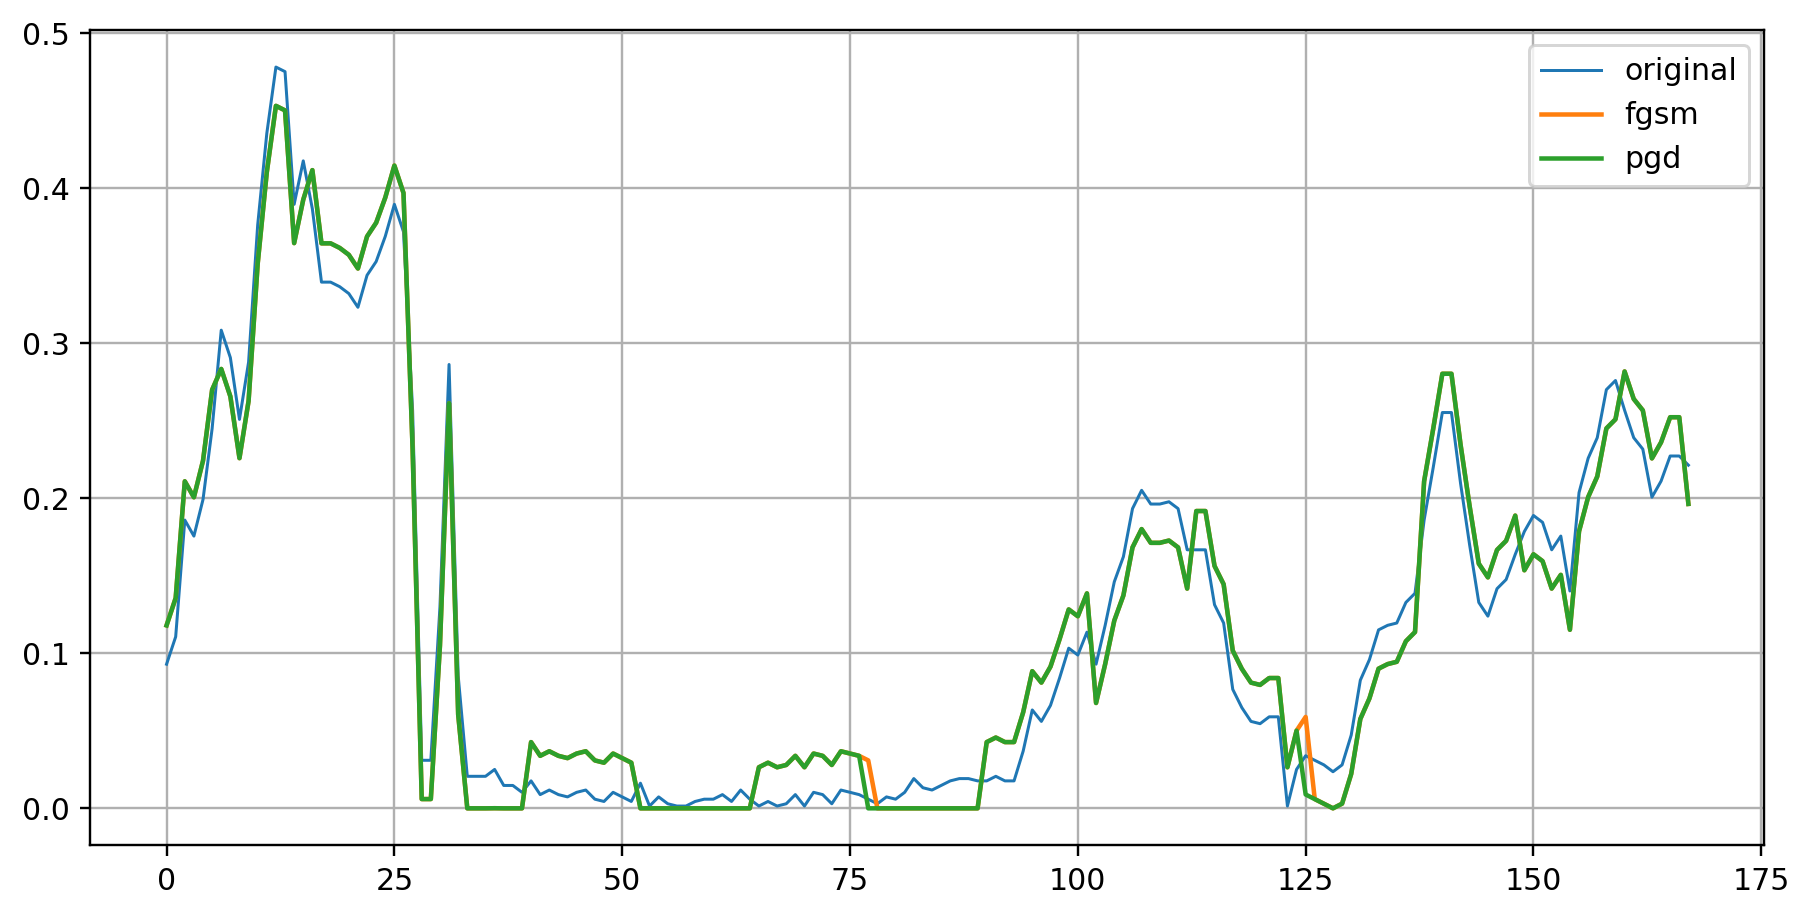

In [26]:
idx = 0
plt.figure(figsize=(10,5), dpi=216)
plt.plot(X_test[idx], label = "original", linewidth=1)
plt.plot(X_adv_fgsm[idx], label = "fgsm")
plt.plot(X_adv_pgd[idx], label = "pgd")
plt.legend()
plt.grid()
plt.savefig('figures/mtm_fgsm_vs_pgd_168.png',bbox_inches='tight')
plt.show()

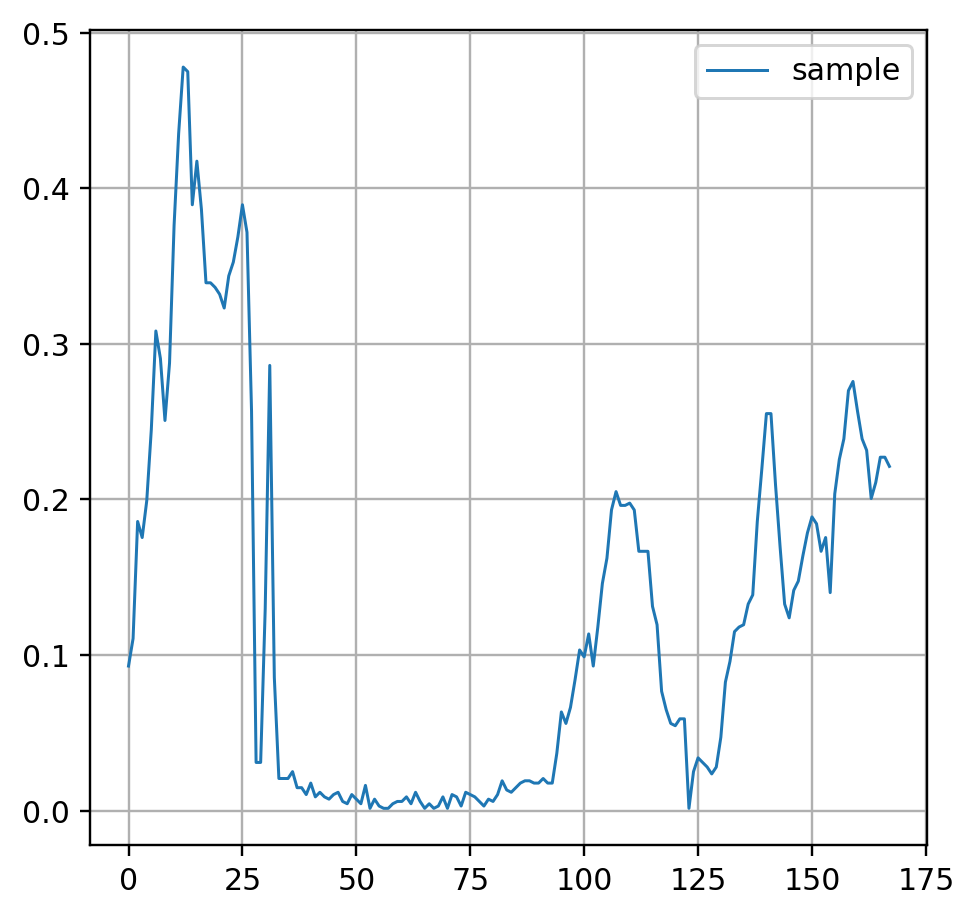

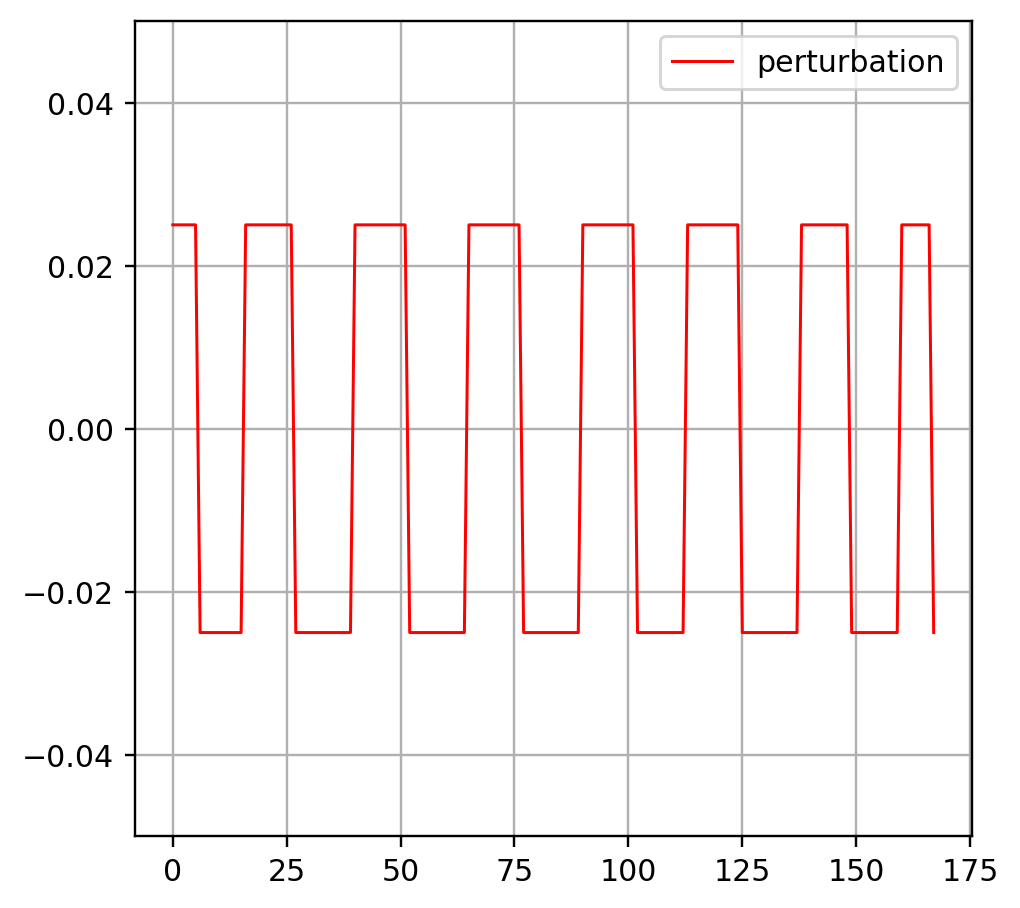

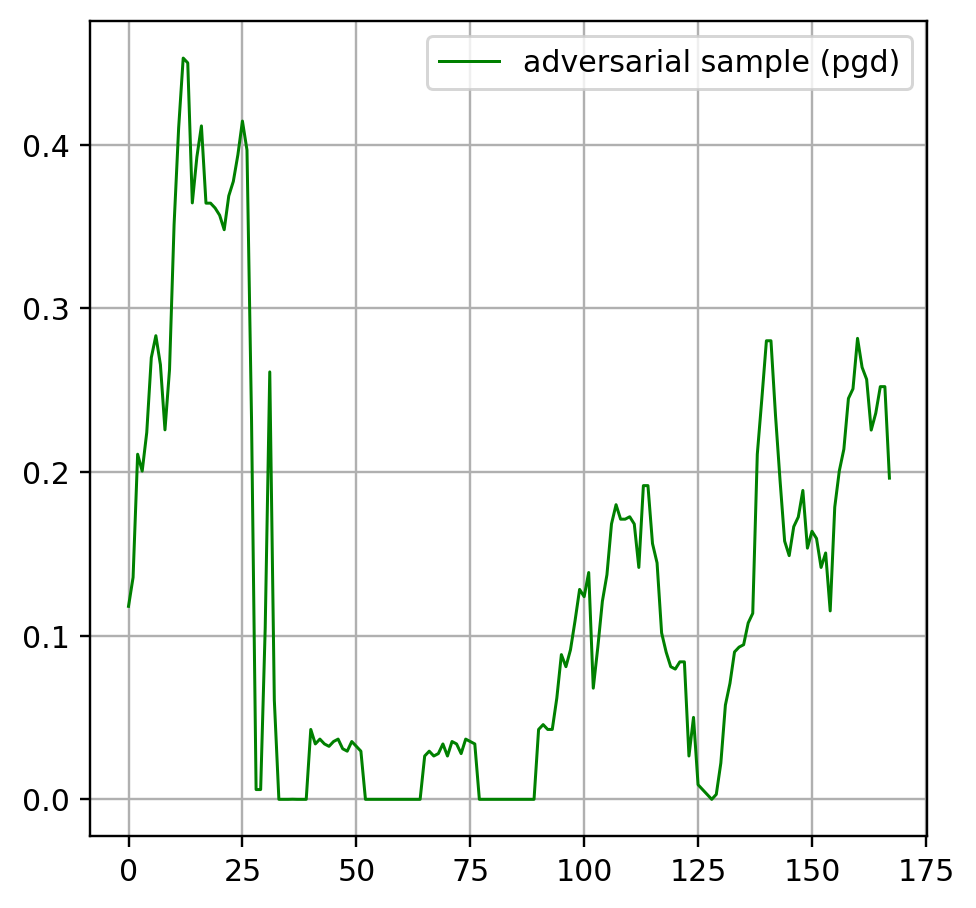

In [27]:
idx = 0

plt.figure(figsize=(5,5), dpi=216)
plt.plot(X_test[idx], label = "sample", linewidth=1)
plt.legend()
plt.grid()
plt.savefig('figures/mtm_original_24.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,5), dpi=216)
plt.plot(perturbation.numpy()[idx], label = "perturbation", color="red", linewidth=1)
plt.ylim(-0.05,0.05)
plt.legend()
plt.grid()
plt.savefig('figures/mtm_perturbation_24.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,5), dpi=216)
plt.plot(X_adv_pgd.numpy()[idx], label = "adversarial sample (pgd)", color="green", linewidth=1)
plt.legend()
plt.grid()
plt.savefig('figures/mtm_adversarial_sample_24.png',bbox_inches='tight')
plt.show()